# Title: Investigating Renter-Occupied Housing Units in LA

# Description: 


Last week, we started to see the counts for renter-occupied housing units and "housing burden index" at the Census-tract level. We saw that there is so much variability of these counts and this index across LA County. Now, let's do a deep dive on the characteristics of these renter housing units. That is, across LA County and in a particular neighborhood:

1. What is the median (in dollars) rent in a contract?
2. What is the median monthly housing costs (in dollars)?
3. How many renter housing units allocates 30 percent or more of their household income in rent?

In essence, we want to understand the "rent" conditions across LA County, and how it may relate to housing burden.

While we ultimately hope to focus on the areas affected by the wildfires, our goal for this Census Data exploration assignment is to further practice our data cleaning and wrangling skills, data visualization, and our mapping skills in Python.

We will be using 5 year estimates data from the US Census' American Community Survey (ACS) through Social Explorer. 

# By: Bryzen Enzo Morales

In [259]:
# loading necessary libraries

import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import folium

%matplotlib inline

# II. Data Investigation: Exploring, Wrangling, Merging Data

In this section, we hope to crete a working dataset for our data visualizations. By selecting particular columns and exploring the types of data, our goal is to know which particular 
variables should be cleaned/modified and what other variables. 

We learned from Lecture 3 that there is a "leading zeroes dilemma." Let's make sure that when we import the data from all the datasets, that they are imported as a "string" already.

### II.A | ACS 2015-2019 5-year Estimates

In [2]:
# importing the data and converting the Geo_FIPS variables as a string

renter_index = pd.read_csv('/home/jovyan/UP221-bryzen/data/acs_15_19_renter_descriptive/acs_15_19_week3.csv',
                          dtype = {'Geo_FIPS':str})

After importing the data, let's investigate the variables included in it.

In [3]:
renter_index.shape

(2346, 153)

In [4]:
renter_index.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2346 entries, 0 to 2345
Columns: 153 entries, Geo_FIPS to ACS19_5yr_B25106046s
dtypes: float64(93), int64(54), object(6)
memory usage: 2.7+ MB


In [5]:
renter_index.head()

,Geo_FIPS,Geo_NAME,Geo_QName,Geo_STUSAB,Geo_SUMLEV,Geo_GEOCOMP,Geo_FILEID,Geo_LOGRECNO,Geo_US,Geo_REGION,...,ACS19_5yr_B25106037s,ACS19_5yr_B25106038s,ACS19_5yr_B25106039s,ACS19_5yr_B25106040s,ACS19_5yr_B25106041s,ACS19_5yr_B25106042s,ACS19_5yr_B25106043s,ACS19_5yr_B25106044s,ACS19_5yr_B25106045s,ACS19_5yr_B25106046s
0,06037101110,Census Tract 1011.10,"Census Tract 1011.10, Los Angeles County, Cali...",ca,140,0,ACSSF,3871,NaN,NaN,...,31.515150,7.272727,24.848480,21.212120,62.42424,43.636360,40.60606,17.575760,15.757580,13.333330
1,06037101122,Census Tract 1011.22,"Census Tract 1011.22, Los Angeles County, Cali...",ca,140,0,ACSSF,3872,NaN,NaN,...,30.303030,7.272727,7.272727,30.303030,42.42424,7.272727,28.48485,32.727270,7.272727,15.151520
2,06037101210,Census Tract 1012.10,"Census Tract 1012.10, Los Angeles County, Cali...",ca,140,0,ACSSF,3873,NaN,NaN,...,64.848490,27.878790,20.606060,50.303030,90.30303,75.757580,41.81818,35.757580,46.060610,30.303030
3,06037101220,Census Tract 1012.20,"Census Tract 1012.20, Los Angeles County, Cali...",ca,140,0,ACSSF,3874,NaN,NaN,...,26.060610,12.727270,22.424240,12.727270,36.96970,26.060610,24.84848,7.878788,18.181820,7.272727
4,06037101300,Census Tract 1013,"Census Tract 1013, Los Angeles County, California",ca,140,0,ACSSF,3875,NaN,NaN,...,7.272727,7.272727,7.272727,7.272727,33.33333,30.303030,14.54545,10.303030,7.272727,7.878788


Woah! There is so much variables in this dataset! An interesting output that we got is that when we used the pd.info() function, we see that it basically just summarized the number per 
types of variables as an aggregate (i.e., 93 are "float", 55 are "integer" and 5 are "object". This is due to the fact that some of these variables were broken down into sub-variables; 
also, the margin of error was included and that they became a "new" variable (for this assignment, the estimate is sufficient for now). Therefore, we need to carefully select the variables we only need. Going back to the data dictionary, we need the FIPS code and the GEO_NAME for the geographic identifier; in addition, we need the following variables:

1. ACS19_5yr_B25058001: Median Contract Rent
2. ACS19_5yr_B25105001: Median Monthly Housing Costs
3. ACS19_5yr_B25106024: Total Renter-Occupied Housing Units
4. ACS19_5yr_B25106028: For families that has less Than $20,000 as household income, these are housing units that allocates 30% or more on their housing costs
5. ACS19_5yr_B25106032: For families that has 20,000 To 34,999 as household income, these are housing units that allocates 30% or more on their housing costs
6. ACS19_5yr_B25106036: For families that has 35,000 To 49,999 as household income, these are housing units that allocates 30% or more on their housing costs
7. ACS19_5yr_B25106040: For families that has 50,000 To 74,999: as household income, these are housing units that allocates 30% or more on their housing costs

**Quick Note:** The reason we included the sixth variable that includes the household income, 50,000 To 74,999, is because of the fact that the median family income in LA County is around [80,000](https://www.census.gov/quickfacts/fact/table/losangelescountycalifornia/LFE305223). We use this as a benchmark to categorize housing units that are economically disadvantaged. That is, their median household income is below, relative to the the median household across the whole LA County.

In [6]:
# isolating the columns we only need

renter_index_v2 = renter_index[["Geo_FIPS", 
                                "Geo_NAME", 
                                "ACS19_5yr_B25058001", 
                                "ACS19_5yr_B25105001",
                                "ACS19_5yr_B25106024",
                                "ACS19_5yr_B25106028", 
                                "ACS19_5yr_B25106032", 
                                "ACS19_5yr_B25106036", 
                                "ACS19_5yr_B25106040"]]

In [7]:
# renaming the new version of our data frame

renter_index_v2.columns = ['Geo_FIPS', 
                           'Census Tract #', 
                           'Median Contract Rent', 
                           'Median Monthly Housing Costs',
                           'Total Renter Housing Units',
                           'less than $20,000', 
                           '20,000 to 34,999', 
                           '35,000 To 49,999', 
                           '50,000 To 74,999']

In [8]:
# ensuring that there are only 9 columns corresponding to the 9 variables we selected

renter_index_v2.shape

(2346, 9)

In [9]:
# ensuring we have the correct data types

renter_index_v2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2346 entries, 0 to 2345
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Geo_FIPS                      2346 non-null   object 
 1   Census Tract #                2346 non-null   object 
 2   Median Contract Rent          2289 non-null   float64
 3   Median Monthly Housing Costs  2310 non-null   float64
 4   Total Renter Housing Units    2346 non-null   int64  
 5   less than $20,000             2346 non-null   int64  
 6   20,000 to 34,999              2346 non-null   int64  
 7   35,000 To 49,999              2346 non-null   int64  
 8   50,000 To 74,999              2346 non-null   int64  
dtypes: float64(2), int64(5), object(2)
memory usage: 165.1+ KB


In [10]:
# sampling one row to confirm the data is sound and good

renter_index_v2.sample()

,Geo_FIPS,Census Tract #,Median Contract Rent,Median Monthly Housing Costs,Total Renter Housing Units,"less than $20,000","20,000 to 34,999","35,000 To 49,999","50,000 To 74,999"
160,06037121802,Census Tract 1218.02,1467.0,2013.0,233,70,14,6,34


Hmmm.. There seems to be something missing in this dataset. Aha! It may be helpful to know the relative frequency (or percent) of those housing units instead of the absolute numbers of renting housing units who allocate 30% or more of their income on housing.

In [11]:
# making a copy of the existing data frame

renter_index_v3 = renter_index_v2.copy()

# creating four new variables 

renter_index_v3['less than 20,000 proportion'] = renter_index_v3['less than $20,000'] / renter_index_v3['Total Renter Housing Units']
renter_index_v3['20,000 to 34,999 proportion'] = renter_index_v3['20,000 to 34,999'] / renter_index_v3['Total Renter Housing Units']
renter_index_v3['35,000 To 49,999 proportion'] = renter_index_v3['35,000 To 49,999'] / renter_index_v3['Total Renter Housing Units']
renter_index_v3['50,000 To 74,999 proportion'] = renter_index_v3['50,000 To 74,999'] / renter_index_v3['Total Renter Housing Units']

renter_index_v3.head()

,Geo_FIPS,Census Tract #,Median Contract Rent,Median Monthly Housing Costs,Total Renter Housing Units,"less than $20,000","20,000 to 34,999","35,000 To 49,999","50,000 To 74,999","less than 20,000 proportion","20,000 to 34,999 proportion","35,000 To 49,999 proportion","50,000 To 74,999 proportion"
0,06037101110,Census Tract 1011.10,1468.0,1853.0,732,147,103,104,53,0.200820,0.140710,0.142077,0.072404
1,06037101122,Census Tract 1011.22,2067.0,2273.0,240,22,27,34,39,0.091667,0.112500,0.141667,0.162500
2,06037101210,Census Tract 1012.10,1276.0,1494.0,1896,545,266,223,160,0.287447,0.140295,0.117616,0.084388
3,06037101220,Census Tract 1012.20,1086.0,1361.0,822,262,114,161,19,0.318735,0.138686,0.195864,0.023114
4,06037101300,Census Tract 1013,2209.0,2094.0,190,9,33,25,8,0.047368,0.173684,0.131579,0.042105


### II.B | CalEnviroScreen 4.0 Housing Burden Variable

In [12]:
# importing data from CalEnviroScreen

environment = pd.read_excel('/home/jovyan/UP221-bryzen/data/environment.xlsx',
                           dtype = {'Census Tract':str})

In [13]:
# isolating the geographic identifier and housing burden variable

environment = environment[["Census Tract", "Housing Burden"]]

In [14]:
# checking the data frame 

environment.sample(3)

,Census Tract,Housing Burden
4078,6059052518,17.6
4612,6073003211,12.9
4986,6067009633,24.7


It seems that a leading zero was not added even when we convert it into a string type. Let's add it using the .str.zfill() function.

In [15]:
# adding a leading zero

environment['Census Tract'] = environment['Census Tract'].str.zfill(11)

# checking the data frame 

environment.sample(3)

,Census Tract,Housing Burden
6610,06037577200,13.4
1995,06037190700,22.9
1983,06019007801,11.6


In [16]:
# checking the data type

environment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8035 entries, 0 to 8034
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Census Tract    8035 non-null   object 
 1   Housing Burden  7890 non-null   float64
dtypes: float64(1), object(1)
memory usage: 125.7+ KB


In [17]:
# renaming the column 'Census Tract' to maintain column name consistency
# from the ACS dataset

environment.columns = ['Geo_FIPS', 
                       'Housing Burden Index']

We all know from the previous assignment that CalEnviroScreen reports every California tract. We note this fact when we merge this dataset to other datasets.

### II.C | 2019 Census Tracts Shapefile from [Census](https://www.census.gov/geographies/mapping-files/time-series/geo/cartographic-boundary.2019.html#list-tab-1883739534)

In [18]:
# importing the shapefile

tracts = gpd.read_file('/home/jovyan/UP221-bryzen/data/ca_2019_tracts.zip')

<Axes: >

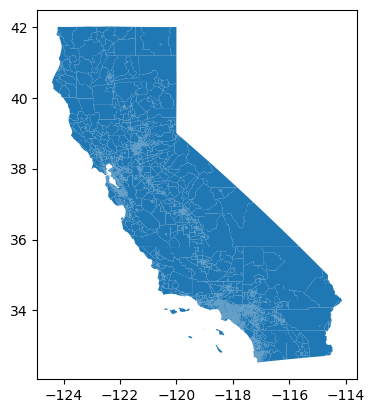

In [19]:
# checking the shape:

tracts.plot()

#WOW!

In [20]:
# checking the data type

tracts.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 8041 entries, 0 to 8040
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   STATEFP   8041 non-null   object  
 1   COUNTYFP  8041 non-null   object  
 2   TRACTCE   8041 non-null   object  
 3   AFFGEOID  8041 non-null   object  
 4   GEOID     8041 non-null   object  
 5   NAME      8041 non-null   object  
 6   LSAD      8041 non-null   object  
 7   ALAND     8041 non-null   int64   
 8   AWATER    8041 non-null   int64   
 9   geometry  8041 non-null   geometry
dtypes: geometry(1), int64(2), object(7)
memory usage: 628.3+ KB


Oh no! The dataset seem to include all tracts in all counties in California. Additionally, the GEOID (or Geo_FIPS) seems to follow the string format from the previous datasets. Bringing in what we know, we can query this data frame by isolating California as a State and Los Angeles as the county. We know, from the Week 3 Lecture, that the State FIPS identifier is "06" and the Los Angeles County's FIPS identifier is "037."

In [21]:
# querying/subsetting the data to Los Angeles County, California

tracts_v2 = tracts[(tracts['STATEFP'] == '06') & (tracts['COUNTYFP'] == '037')]

In [22]:
# checking the shape of the data 

tracts_v2.shape

(2344, 10)

In [23]:
# randomly sampling 6 rows to make sure all of them have the necessary conditions

tracts_v2.sample(6)

,STATEFP,COUNTYFP,TRACTCE,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
4662,06,037,480702,1400000US06037480702,06037480702,4807.02,CT,2176087,0,"POLYGON ((-118.17799 34.10548, -118.17799 34.1..."
2980,06,037,920114,1400000US06037920114,06037920114,9201.14,CT,2835168,0,"POLYGON ((-118.58423 34.42518, -118.58116 34.4..."
594,06,037,401800,1400000US06037401800,06037401800,4018,CT,6016700,12321,"POLYGON ((-117.73681 34.11084, -117.73648 34.1..."
2227,06,037,502302,1400000US06037502302,06037502302,5023.02,CT,750552,0,"POLYGON ((-118.07395 33.97252, -118.07084 33.9..."
4368,06,037,241001,1400000US06037241001,06037241001,2410.01,CT,904093,2395,"POLYGON ((-118.28002 33.931, -118.27959 33.931..."
972,06,037,117202,1400000US06037117202,06037117202,1172.02,CT,1813873,0,"POLYGON ((-118.48503 34.2393, -118.48499 34.24..."


<Axes: >

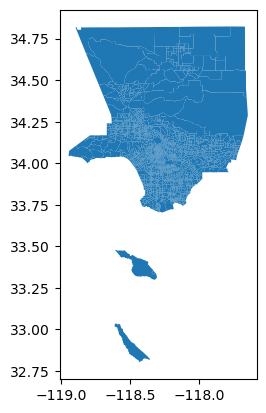

In [24]:
# mapping

tracts_v2.plot()

Successful! Now, we still need to merge our ACS, CalEnviroScreen, and these tracts shapefile together. 

### II. D | Three Datasets Altogether!

In [25]:
# merging the three datasets simultaneously
# by nesting the pd.merge function

index = pd.merge(pd.merge(renter_index_v3, 
                    tracts_v2,
                   left_on = 'Geo_FIPS',
                   right_on = 'GEOID'), environment, on = 'Geo_FIPS')

In [26]:
# diagnosing the merged datasets

index.head()

,Geo_FIPS,Census Tract #,Median Contract Rent,Median Monthly Housing Costs,Total Renter Housing Units,"less than $20,000","20,000 to 34,999","35,000 To 49,999","50,000 To 74,999","less than 20,000 proportion",...,COUNTYFP,TRACTCE,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry,Housing Burden Index
0,06037101110,Census Tract 1011.10,1468.0,1853.0,732,147,103,104,53,0.200820,...,037,101110,1400000US06037101110,06037101110,1011.10,CT,1142401,0,"POLYGON ((-118.30075 34.25961, -118.30076 34.2...",32.5
1,06037101122,Census Tract 1011.22,2067.0,2273.0,240,22,27,34,39,0.091667,...,037,101122,1400000US06037101122,06037101122,1011.22,CT,2644045,0,"POLYGON ((-118.3032 34.27333, -118.2997 34.275...",14.8
2,06037101210,Census Tract 1012.10,1276.0,1494.0,1896,545,266,223,160,0.287447,...,037,101210,1400000US06037101210,06037101210,1012.10,CT,650690,0,"POLYGON ((-118.29945 34.25598, -118.29104 34.2...",31.5
3,06037101220,Census Tract 1012.20,1086.0,1361.0,822,262,114,161,19,0.318735,...,037,101220,1400000US06037101220,06037101220,1012.20,CT,698886,0,"POLYGON ((-118.28592 34.25589, -118.28498 34.2...",33.9
4,06037101300,Census Tract 1013,2209.0,2094.0,190,9,33,25,8,0.047368,...,037,101300,1400000US06037101300,06037101300,1013,CT,2581214,0,"POLYGON ((-118.27822 34.25166, -118.27692 34.2...",18.6


Great! All of our variables are in here! 

**Quick Note:** In here, we practiced nesting functions. The left_on shows that the dataset, renter_index_v3 dataset, has the key "Geo_FIPS" and this string is going to be merged to the GEOID variable in the tracts_v2 dataset. The resulting dataset shows only one column of FIPS code, Geo_FIPS. This creates another dataset, through which, if nested, will have the same "join" function with the environment dataset.

We can proceed to the fun part: visualizing the data.

# III. Data Visualization

### III.A | Plots and Graphs

First, we want to get to know our data first. Let's plot a histogram of the median contract rent and the median monthly housing costs simultaneously using [matplotlib](https://www.geeksforgeeks.org/overlapping-histograms-with-matplotlib-in-python).

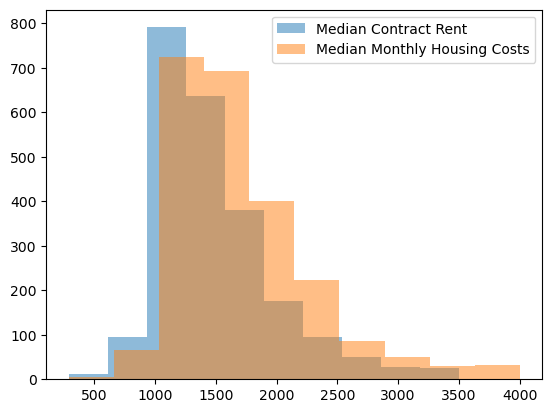

In [265]:
# plotting histogram of the two variables of interest

plt.hist(index['Median Contract Rent'],  
         alpha=0.5, 
         label='Median Contract Rent') 
  
plt.hist(index['Median Monthly Housing Costs'], 
         alpha=0.5, 
         label='Median Monthly Housing Costs') 
plt.legend(loc='upper right') 
plt.show()

Now, let's see the distribution of the census tracts and their respective proportion of renting units who allocates 30% or more of their income to their renting cost for each income bracket.

<Axes: >

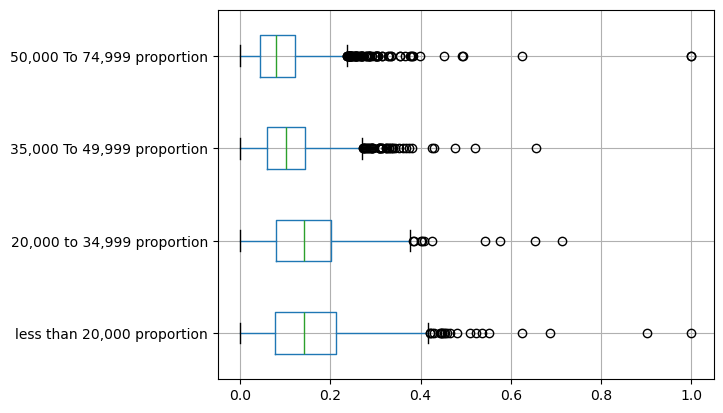

In [245]:
index.boxplot(column = ['less than 20,000 proportion', 
                        '20,000 to 34,999 proportion', 
                        '35,000 To 49,999 proportion', 
                        '50,000 To 74,999 proportion'],
             vert = False)

This plot shows many outliers across all the income brackets. Disregarding the outliers in the data, we see that the variability of the proportion of Census Tracts whose renters allocate 30% of their income on renting costs, decreases as the income bracket goes up. This is consistent with economic theory and principles of income and consumption (in this case, consumption is the housing cost).

Second, it may be relevant to also know if the housing burden variable from the CalEnviroScreen 4.0 is correlated with allocation of income to renting costs. That is, does higher proportion, within a neighborhood, of renter who allocated 30% of their income or more among all the income bracket means that they have higher housing burden? Though this is intuitive, we may have to test this "empirically" before we jump into any conclusions. For this, let's use the .regplot() function from the seaborn library to show the line of best fit.

<Axes: xlabel='less than 20,000 proportion', ylabel='Housing Burden Index'>

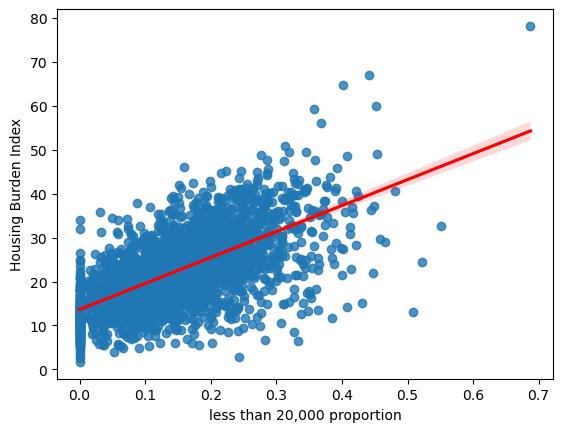

In [71]:
# scatter plot with line of best fit for income bracket: less than 20,000
sns.regplot(data = index,
                  x='less than 20,000 proportion', 
                  y='Housing Burden Index',
           robust = True,
           line_kws = dict(color="r"))

<Axes: xlabel='20,000 to 34,999 proportion', ylabel='Housing Burden Index'>

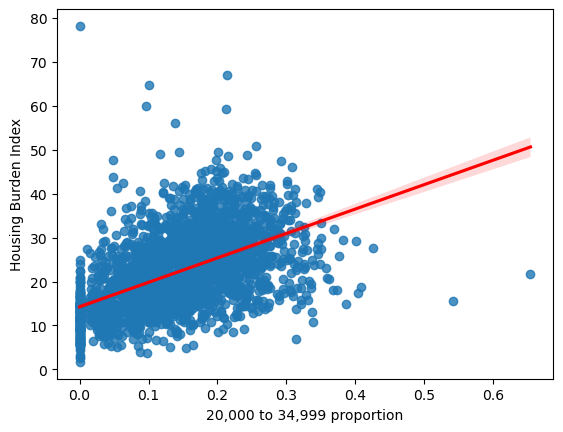

In [72]:
# scatter plot with line of best fit for income bracket: 20,000 to 34,999 

sns.regplot(data = index,
                  x='20,000 to 34,999 proportion', 
                  y='Housing Burden Index',
           robust = True,
           line_kws=dict(color="r"))

<Axes: xlabel='35,000 To 49,999 proportion', ylabel='Housing Burden Index'>

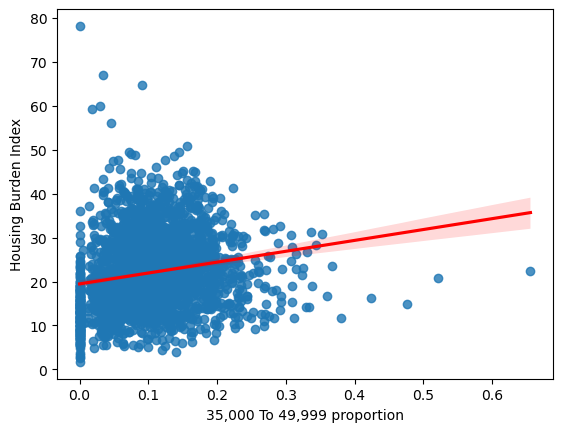

In [266]:
# scatter plot with line of best fit for income bracket: 35,000 To 49,999

sns.regplot(data = index,
                  x='35,000 To 49,999 proportion', 
                  y='Housing Burden Index',
           robust = True,
           line_kws=dict(color="r"))

<Axes: xlabel='50,000 To 74,999 proportion', ylabel='Housing Burden Index'>

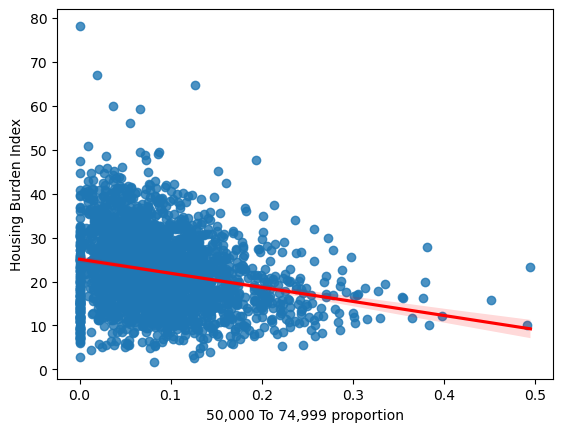

In [74]:
# scatter plot with line of best fit for income bracket: 50,000 To 74,999

sns.regplot(data = index,
                  x='50,000 To 74,999 proportion', 
                  y='Housing Burden Index',
           robust = True,
           line_kws=dict(color="r"))

We see that the plot shows a positive, linear, moderate relationship between housing burden index and proportion of renters who allocate 30% or more of their household income to renting costs, under the less than $20,000 income bracket. However, what is particularly starking to see is that as we go through a higher income bracket, this relationship weakens until it changes to the negative direction! That is, higher housing burden, is typically associated now with lower proportion of tracts whose renters allocates 30% or more of their household income towards renting costs as income bracket goes high. This is consistent, again, with economic theory about income and consumption.

### III.B | Maps

Now that we know some of the properties of our variables, mapping some of the variables we have may also be helpful. Let's start by mapping the spatial distribution of median contract rent across LA County.

In [267]:
index_v2 = gpd.GeoDataFrame(index, geometry=index['geometry'])

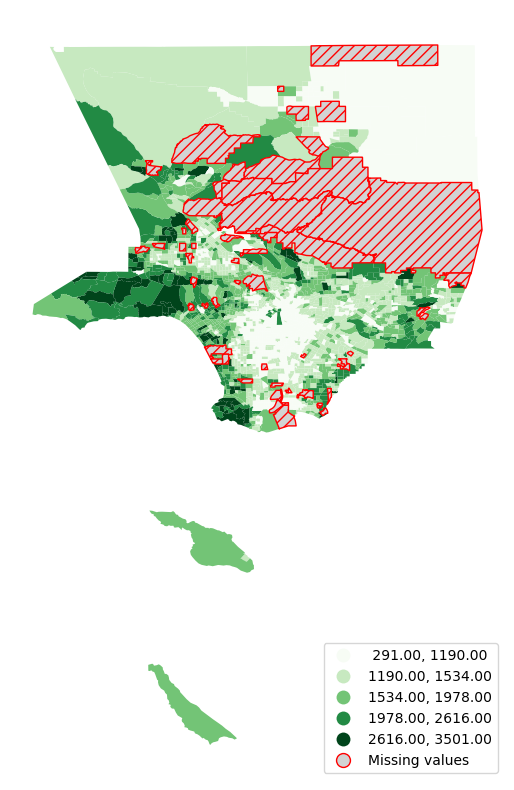

In [268]:
# plotting

contract_rent = index_v2.plot(
    figsize=(12,10),
    column="Median Contract Rent",
    scheme="naturalbreaks",
    k=5, 
    legend = True,
    legend_kwds={'loc': 'lower right'},
    missing_kwds={
        "color": "lightgrey",
        "edgecolor": "red",
        "hatch": "///",
        "label": "Missing values"},
    cmap = 'Greens')

contract_rent.set_axis_off()

We see that there seems to be "clustering" of high median contract rent on the West Side of LA County and around the Long Beach area. It may be relevant for us to map the top 10 highest median contract rent in LA County; let's sort the data using a more interactive map:

In [269]:
# sorting the values to extract the top ten highest median contract rent across LA County

high_contract_rent = index_v2.sort_values(by='Median Contract Rent', ascending = False).head(10)

In [270]:
# converting the geodata frame to geojson features

high_contract_rent_json = high_contract_rent.geometry.__geo_interface__

In [271]:
# setting a default map

m = folium.Map(location=[34.2,-118.2], 
               zoom_start = 10)

# creating an interactive map

folium.GeoJson(high_contract_rent_json,
               weight = 1,
               color = "orange",
               fill_color = "red",
               fill_opacity = 1).add_to(m)

m

Great! We see that the neighborhoods included in the top ten median contract rent across LA county is spread out. What this map, however, highlights is that in 2019 (using 2015-2019 5 year ACS estimates), neighborhoods around where the wildfires are located at has one of the highest median contract rent. This is helpful for our analysis that we are going to be doing moving forward.

In [1]:
# saving the map
m.save('high_rent_LA.html')

NameError: name 'm' is not defined

# Sources (For future references)

#### Mapping

Folium [GeoJSON](https://python-visualization.github.io/folium/latest/user_guide/geojson/geojson.html); GeoPandas [Basic Plotting Tools](https://geopandas.org/en/stable/docs/user_guide/mapping.html); GeoPandas [Chloropleth](https://geopandas.org/en/stable/gallery/choropleths.html); GeoPandas and Folium [Converting to GeoJSON features](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.__geo_interface__.html)

#### Pandas and Statistical Visualizations

Pandas [Merge](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html); Pandas [Boxplot](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html)

#### [Color Guides](https://matplotlib.org/stable/users/explain/colors/colormaps.html)